<small>This notebook was put together by [wesley beckner](http://wesleybeckner.github.io)</small>


<a id='top'></a>

# Contents

[scrape data](#scrape)

[create descriptors](#descriptors)

[multi-layer perceptron (MLP) regressor](#nn)

[create static files](#static)

In [3]:
import statistics
import requests
import json
import pickle
import salty
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from scipy import stats
from scipy.stats import uniform as sp_rand
from scipy.stats import mode
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
import os
import sys
import pandas as pd
from collections import OrderedDict
from numpy.random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from math import log
from time import sleep
%matplotlib inline

class dev_model():
    def __init__(self, coef_data, data):
        self.Coef_data = coef_data
        self.Data = data
        
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

<a id='scrape'></a>

# Scrape ILThermo Data

[back to top](#top)

ILThermo has specific 4-letter tags for the properties in the database. These can be determined by inspecting the web elements on their website.

Melting point: prp=lcRG (note this in the paper_url string)

All that needs to be changed to scrape other property data is the 4-letter tag and the directory in which to save the information.

In [12]:
paper_url = "http://ilthermo.boulder.nist.gov/ILT2/ilsearch?"\
    "cmp=&ncmp=1&year=&auth=&keyw=&prp=lcRG"
    
r = requests.get(paper_url)
header = r.json()['header']
papers = r.json()['res']
i = 1
data_url = 'http://ilthermo.boulder.nist.gov/ILT2/ilset?set={paper_id}'
for paper in papers[:1]:
    
    r = requests.get(data_url.format(paper_id=paper[0]))
    data = r.json()['data']
    with open("../salty/data/MELTING_POINT/%s.json" % i, "w") as outfile:
        json.dump(r.json(), outfile)
    #then do whatever you want to data like writing to a file
    sleep(0.5) #import step to avoid getting banned by server
    i += 1

<a id='descriptors'></a>

# Create Descriptors

[back to top](#top)

The scraped data is in the form of a json file. The json files contain all the experimental information NIST has archived, including methods and experimental error!

Unfortunately the IUPAC names in the database are imperfect. We address this after the following cell.

In [24]:
###add JSON files to density.csv
outer_old = pd.DataFrame()
outer_new = pd.DataFrame()
number_of_files = 2266

for i in range(2266):
    with open("../salty/data/DENSITY/%s.json" % str(i+1)) as json_file:
        
        #grab data, data headers (names), the salt name
        json_full = json.load(json_file)
        json_data = pd.DataFrame(json_full['data'])
        json_datanames = np.array(json_full['dhead'])
        json_data.columns =  json_datanames
        json_saltname = pd.DataFrame(json_full['components'])

        inner_old = pd.DataFrame()
        inner_new = pd.DataFrame()

        #loop through the columns of the data, note that some of the 
        #json files are missing pressure data. 
        if len(json_data.columns.values) > 3:
            print(json_data.columns.values)
        for indexer in range(len(json_data.columns)):
            grab=json_data.columns[indexer]
            list = json_data[grab]
            #my_list grabs first element
            #change l[0] to l[1] for error
            my_list = [l[0] for l in list]
            dfmy_list = pd.DataFrame(my_list)
            dfmy_list.columns = [json_datanames[indexer][0]]
            inner_new = pd.concat([dfmy_list, inner_old], axis=1)
            inner_old = inner_new

        #add the name of the salt    
        inner_old['salt_name']=json_saltname.iloc[0][3]           

        #add to the growing dataframe
        outer_new = pd.concat([inner_old, outer_old], axis=0)
        outer_old = outer_new
# pd.DataFrame.to_csv(outer_old, path_or_buf='../salty/data/density.csv', index=False)

We can view an example of the raw data:

In [26]:
df.to_csv("ulysses")

       Pressure, kPa  Specific density, kg/m<SUP>3</SUP>  Temperature, K
count     654.000000                          654.000000      654.000000
mean    37341.492164                         1272.809786      333.530454
std     53623.961553                           26.611532       48.049042
min       100.000000                         1163.000000      278.100000
25%       101.325000                         1261.725000      303.020000
50%     10012.000000                         1276.500000      313.200000
75%     50000.000000                         1288.700000      348.008500
max    200000.000000                         1342.000000      472.400000


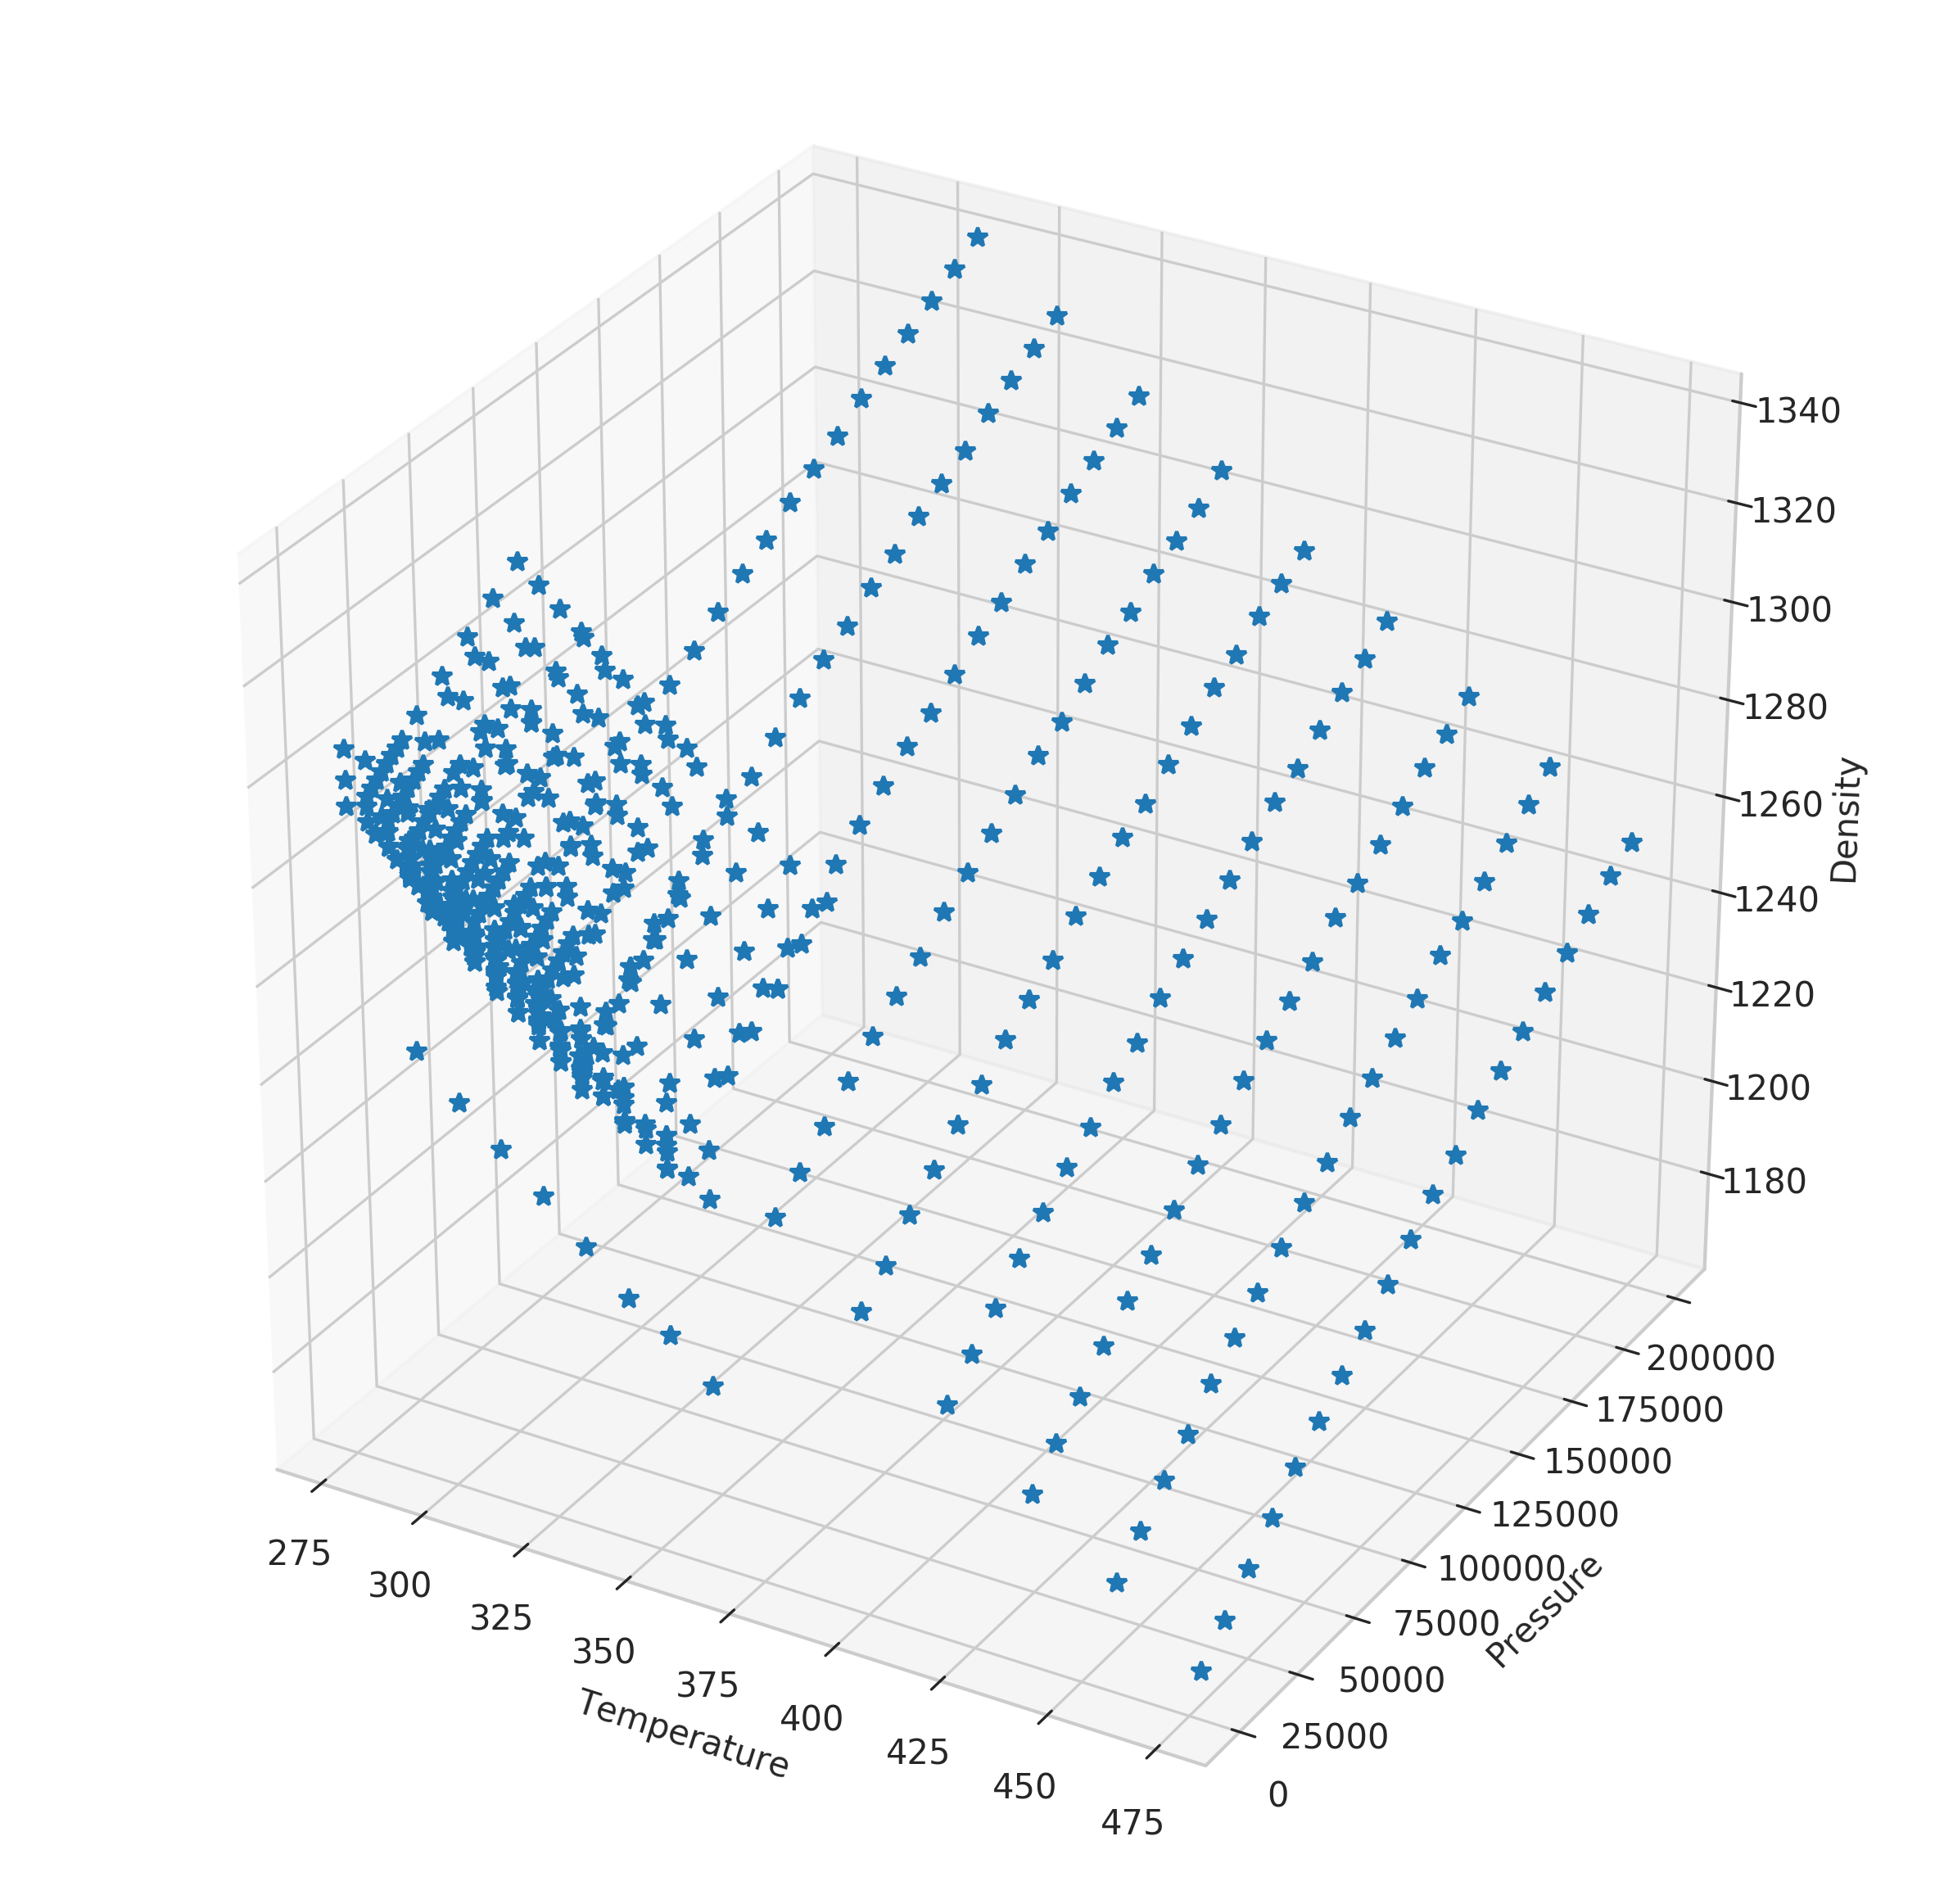

In [25]:
from mpl_toolkits.mplot3d import Axes3D
cols = outer_old.columns
df = outer_old.loc[outer_old["salt_name"] == "1-ethyl-3-methylimidazolium tetrafluoroborate"]
df = df[cols[[1,2,4]]]
df = df.astype(float)
print(df.describe())

df.reset_index(inplace=True, drop=True)
#df.boxplot()
df.dtypes

with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(10,10), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(df["Temperature, K"],df["Pressure, kPa"] ,
            df["Specific density, kg/m<SUP>3</SUP>"],linestyle="None", marker="*")
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Pressure')
    ax.set_zlabel('Density')

       Pressure, kPa  Specific density, kg/m<SUP>3</SUP>  Temperature, K
count      35.000000                           35.000000       35.000000
mean      101.230714                         1281.177143      298.175429
std         0.148161                            2.858227        0.169989
min       101.000000                         1277.600000      298.100000
25%       101.000000                         1279.900000      298.150000
50%       101.325000                         1280.000000      298.150000
75%       101.325000                         1280.450000      298.150000
max       101.325000                         1290.000000      299.150000


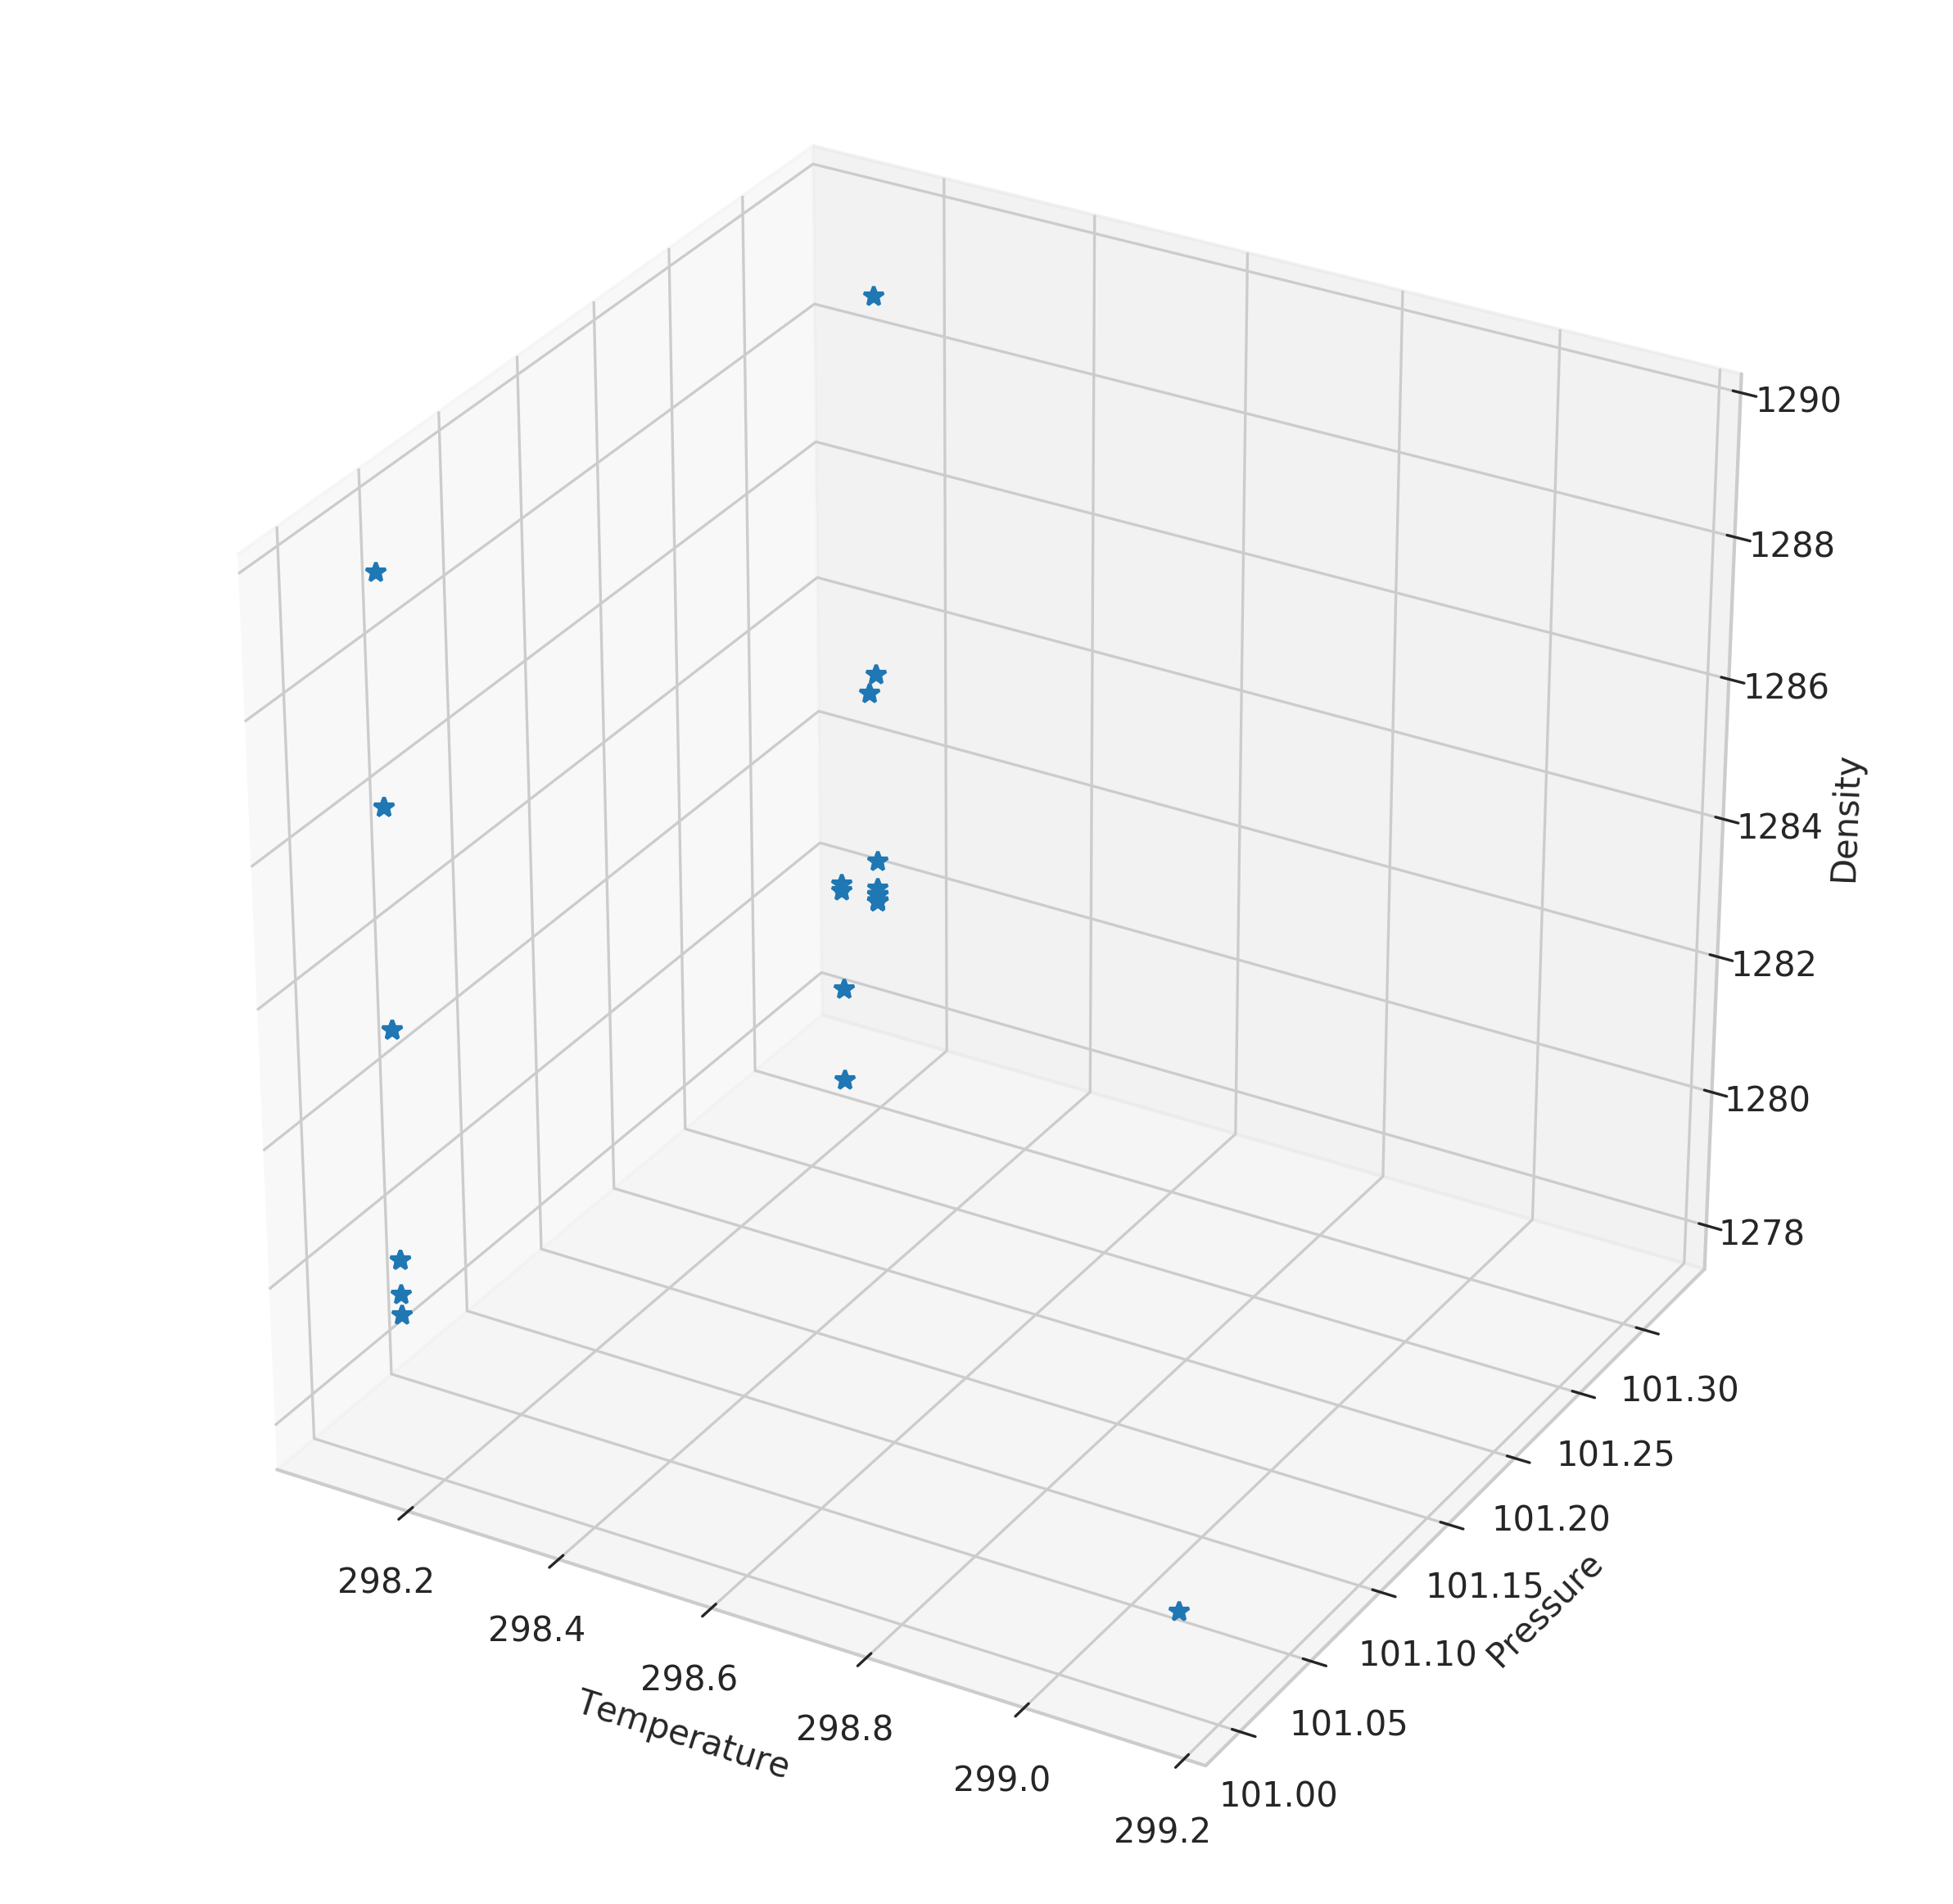

In [13]:
from mpl_toolkits.mplot3d import Axes3D
df = pd.read_csv('../salty/data/density.csv',delimiter=',')
cols = df.columns
df = df.loc[df["salt_name"] == "1-ethyl-3-methylimidazolium tetrafluoroborate"]
df = df[cols[[1,2,4]]]
df = df.astype(float)
df = df.loc[df["Temperature, K"] > 298]
df = df.loc[df["Temperature, K"] < 300]
df = df.loc[df["Pressure, kPa"] > 100]
df = df.loc[df["Pressure, kPa"] < 110]
print(df.describe())

df.reset_index(inplace=True, drop=True)
#df.boxplot()
df.dtypes

with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(10,10), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(df["Temperature, K"],df["Pressure, kPa"] ,
            df["Specific density, kg/m<SUP>3</SUP>"],linestyle="None", marker="*")
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Pressure')
    ax.set_zlabel('Density')

Dealing with messy data is commonplace. *Even highly vetted data in ILThermo.*

I addressed inaccuracies in the IUPAC naming by first parsing the IUPAC names into two strings (caiton and anion) and then hand checking the strings that had more than two components. I then matched these **weird** IUPAC names to their correct SMILES representations. These are stored in the salty database file cationInfo.csv and anionInfo.csv.

In [132]:
df = pd.read_csv('../salty/data/density.csv',delimiter=',')
salts = pd.DataFrame(df["salt_name"])
salts = salts.rename(columns={"salt_name": "salts"})
anions= []
cations= []
missed = 0
for i in range(df.shape[0]):
    if len(salts['salts'].iloc[i].split()) == 2:
        cations.append(salts['salts'].iloc[i].split()[0])
        anions.append(salts['salts'].iloc[i].split()[1])
    elif len(salts['salts'].iloc[i].split()) == 3:
        if("sulfate" in salts['salts'].iloc[i] or\
        "phosphate" in salts['salts'].iloc[i] or\
        "phosphonate" in salts['salts'].iloc[i] or\
        "carbonate" in salts['salts'].iloc[i]):
            #these strings have two-word anions
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            cations.append(salts['salts'].iloc[i].split()[0])
            anions.append(first + ' ' + second)
        elif("1:1" in salts["salts"].iloc[i]):
            #some strings contain the mixing ratio
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first)
            anions.append(second)
        elif("(OC-6-11)-hexafluoroantimonate(1-)" in salts["salts"].iloc[i]):
            #special case
            cations.append("1-butyl-3-methylimidazolium")
            anions.append("hexafluoroantimonate")
        elif("1,3-propanediol, 2-amino-2-(hydroxymethyl)-," in salts["salts"].iloc[i]):
            #special case
            cations.append("2-amino-2-(hydroxymethyl)-1,3-propanediol")
            anions.append("hydrochloride")
        else:
            #assume the rest are two-word cations
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            cations.append(first + ' ' + second)
            anions.append(third)
    elif len(salts['salts'].iloc[i].split()) == 4:
        #this particular string block contains (1:1) at end of name
        if("1,1,2,3,3,3-hexafluoro-1-propanesulfonate" in salts['salts'].iloc[i]):
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            cations.append(first + ' ' + second)
            anions.append(salts['salts'].iloc[i].split()[2])
        else:
            #and two word anion
            first = salts['salts'].iloc[i].split()[1]
            second = salts['salts'].iloc[i].split()[2]
            anions.append(first + ' ' + second)
            cations.append(salts['salts'].iloc[i].split()[0])
    elif("2-aminoethanol-2-hydroxypropanoate" in salts['salts'].iloc[i]):
        #one of the ilthermo salts is missing a space between cation/anion
        anions.append("2-hydroxypropanoate")
        cations.append("2-aminoethanol")
    elif len(salts['salts'].iloc[i].split()) == 5:
        if("bis[(trifluoromethyl)sulfonyl]imide" in salts['salts'].iloc[i]):
            anions.append("bis(trifluoromethylsulfonyl)imide")
            first = salts['salts'].iloc[i].split()[0]
            second = salts['salts'].iloc[i].split()[1]
            third = salts['salts'].iloc[i].split()[2]
            fourth = salts['salts'].iloc[i].split()[3]
            cations.append(first + ' ' + second + ' ' + third + ' ' + fourth)
        if("trifluoro(perfluoropropyl)borate" in salts['salts'].iloc[i]):
            anions.append("trifluoro(perfluoropropyl)borate")
            cations.append("N,N,N-triethyl-2-methoxyethan-1-aminium")
    elif("1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)"
        in salts['salts'].iloc[i]):
        anions.append("trifluoroacetic acid")
        cations.append("1-ethyl-3-methyl-1H-imidazolium")
    elif("L-alanine, 1-methylethyl ester, dodecyl sulfate (1:1)"
        in salts['salts'].iloc[i]):
        anions.append("dodecyl sulfate")
        cations.append("L-alanine, 1-methylethyl ester")
    else:
        print(salts['salts'].iloc[i])
        missed += 1
anions = pd.DataFrame(anions, columns=["name-anion"])
cations = pd.DataFrame(cations, columns=["name-cation"])
# salts=pd.read_csv('../salty/data/salts_with_smiles.csv',delimiter=',')
# new_df = pd.concat([salts["name-cation"], salts["name-anion"], salts["Temperature, K"],\
#                     salts["Pressure, kPa"], salts["Specific density, kg/m<SUP>3</SUP>"]],\
#                    axis = 1)
print(missed)

0


After appending SMILES to the dataframe, we're ready to add RDKit descriptors. Because the descriptors are specific to a given cation and anion, and there are many repeats of these within the data (~10,000 datapoints with ~300 cations and ~150 anions) it is much faster to use pandas to append existing descriptor dataframes to our growing dataframe from ILThermo.

In [15]:
cationDescriptors = salty.load_data("cationDescriptors.csv")
cationDescriptors.columns = [str(col) + '-cation' for col in cationDescriptors.columns]
anionDescriptors = salty.load_data("anionDescriptors.csv")
anionDescriptors.columns = [str(col) + '-anion' for col in anionDescriptors.columns]

In [16]:
# new_df = pd.concat([cations, anions, df["Temperature, K"], df["Pressure, kPa"],\
#                     df["Specific density, kg/m<SUP>3</SUP>"]], axis=1)
new_df = pd.merge(cationDescriptors, new_df, on="name-cation", how="right")
new_df = pd.merge(anionDescriptors, new_df, on="name-anion", how="right")
new_df.dropna(inplace=True) #remove entries not in smiles database

In [135]:
pd.DataFrame.to_csv(new_df, path_or_buf='../salty/data/density_premodel.csv', index=False)

**At this point I introduce a new class of objects called devmodel. **

devmodel is a pickle-able object. self.Data contains the scaled/centered feature data and log of the property data as well as the original IUPAC names and SMILES. This makes it easy to consistently unpickle the devmodel and begin using it in an sklearn algorithm without making changes to the dataframe. Self.Coef_data contains the mean and standard deviation of the features so that structure candidates in our genetic algorithm can be scaled and centered appropriately.

It is important to make any addition subselections of the dataset before you scale and center the data - this is the purpose of the cells bellow.

In [18]:
property_model = "density"
df = pd.DataFrame.from_csv('../salty/data/%s_premodel.csv' % property_model, index_col=None)

In [19]:
###Make any subselections of the data here
down_select = df
down_select = down_select.loc[down_select["name-anion"].str.contains("methyl sulfate")]
# down_select = down_select.loc[down_select["Temperature, K"] < 315]
# down_select = down_select.loc[down_select["Temperature, K"] > 290]
# down_select = down_select.loc[down_select["Pressure, kPa"] < 200]
# down_select = down_select.loc[down_select["Pressure, kPa"] > 100]

unique_salts = down_select["smiles-cation"] + down_select["smiles-anion"]


print("{}\t{}".format("Number of unique salts:",len(unique_salts.unique())))
print("{}\t{}".format("Total data points:",len(unique_salts)))
print("{}\t{}{}{}".format("Temperature range:",down_select["Temperature, K"].min(),"-",
                         down_select["Temperature, K"].max()))
print("{}\t{}{}{}".format("Pressure range:",down_select["Pressure, kPa"].min(),"-",
                         down_select["Pressure, kPa"].max()))
print("{}\t{}{}{}".format("Density range:",down_select["Specific density, kg/m<SUP>3</SUP>"].min(),"-",
                         down_select["Specific density, kg/m<SUP>3</SUP>"].max()))

Number of unique salts:	7
Total data points:	89
Temperature range:	283.15-373.15
Pressure range:	101.0-101.325
Density range:	1031.2-1305.9


In [6]:
down_select.reset_index(drop=True, inplace=True)
df = down_select

In [7]:
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
property_scale = dataDf["Specific density, kg/m<SUP>3</SUP>"].apply(lambda x: log(float(x)))
cols = dataDf.columns.tolist()
instance = StandardScaler()
data = pd.DataFrame(instance.fit_transform(dataDf.iloc[:,:-1]), columns=cols[:-1])
df = pd.concat([data, property_scale, metaDf], axis=1)
mean_std_of_coeffs = pd.DataFrame([instance.mean_,instance.scale_], columns=cols[:-1])
devmodel = dev_model(mean_std_of_coeffs, df)
pickle_out = open("../salty/data/%s_devmodel.pkl" % property_model, "wb")
pickle.dump(devmodel, pickle_out)
pickle_out.close()

In [2]:
property_model = "density"
df = pd.DataFrame.from_csv('../salty/data/%s_premodel.csv' % property_model, index_col=None)
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
property_scale = dataDf["Specific density, kg/m<SUP>3</SUP>"].apply(lambda x: log(float(x)))
cols = dataDf.columns.tolist()
instance = StandardScaler()
data = pd.DataFrame(instance.fit_transform(dataDf.iloc[:,:-1]), columns=cols[:-1])
df = pd.concat([data, property_scale, metaDf], axis=1)
mean_std_of_coeffs = pd.DataFrame([instance.mean_,instance.scale_], columns=cols[:-1])
devmodel = dev_model(mean_std_of_coeffs, df)
pickle_out = open("../salty/data/%s_devmodel.pkl" % property_model, "wb")
pickle.dump(devmodel, pickle_out)
pickle_out.close()

<a id='nn'></a>

# MLPRegressor

[back to top](#top)

I set avg_selected_features to the number of features I want to include based on the box-whiskers plot, t-tests, and progressively dropped features model. I've set this value to 20 in the cell bellow.

In [20]:
property_model = "density"
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
rawdf = devmodel.Data
#rawdf = rawdf.sample(frac=1)
metadf = rawdf.select_dtypes(include=["object"])
datadf = rawdf.select_dtypes(include=[np.number])

data=np.array(datadf)

n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))

I usually optimize my MLP regressor hyper parameters with any new type of dataset. This takes a long time to run so I use the Hyak supercomputer.

In [ ]:
###Randomized Search NN Characterization
param_grid = {"activation": ["identity", "logistic", "tanh", "relu"],\
             "solver": ["lbfgs", "sgd", "adam"], "alpha": sp_rand(),\
             "learning_rate" :["constant", "invscaling", "adaptive"],\
             "hidden_layer_sizes": [randint(100)]}

model = MLPRegressor(max_iter=400,tol=1e-8)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,\
                          n_jobs=-1, n_iter=10)
grid_result = grid.fit(X_train, Y_train)

print(grid_result.best_estimator_)

In [21]:
model = MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
model.fit(X_train,Y_train)

MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000000.0, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)

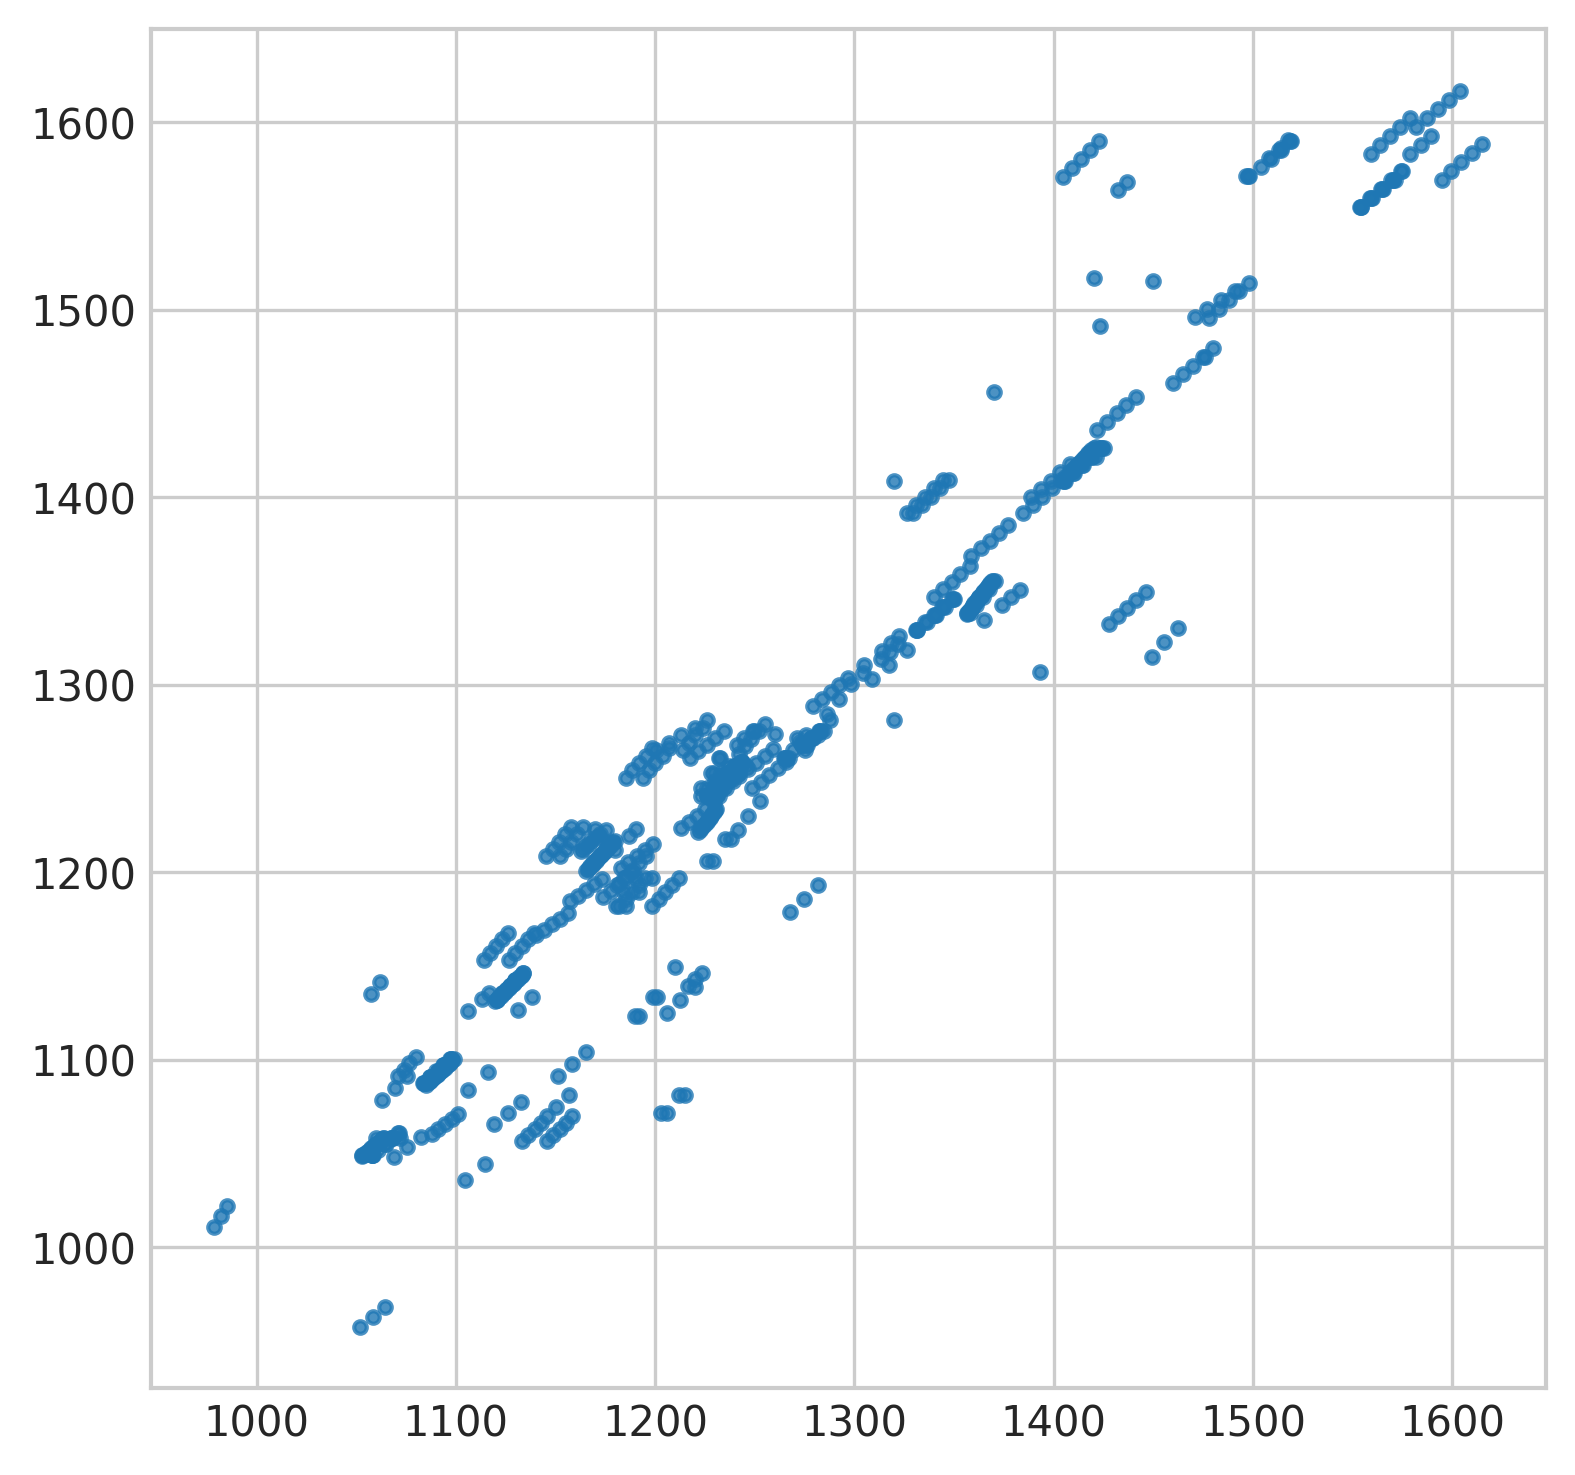

In [22]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(np.exp(Y_test),np.exp(model.predict(X_test)),\
            marker=".",linestyle="",alpha=0.8)

<a id='static'></a>

# Save the final model to be used in the [GAINS](https://github.com/wesleybeckner/gains) fitness test

[back to top](#top)

In [11]:
pickle_out = open("../salty/data/density_model_4.sav", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

coeffs = devmodel.Coef_data
pd.DataFrame.to_csv(coeffs, path_or_buf=\
        '../salty/data/density_model_4_descriptors.csv', index=False)